In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import time

In [3]:
# Check if MPS (Apple Silicon GPU) is available - more thorough checking
def get_device():
    if not torch.backends.mps.is_available():
        print("MPS not available - checking why...")
        if not torch.backends.mps.is_built():
            print("PyTorch not compiled with MPS support. Verify your PyTorch version (needs 1.12+ and proper installation)")
        else:
            print("PyTorch has MPS support but MPS is not available on this device")
        return torch.device("cpu")
    
    # MPS is available, but verify we can actually create a tensor on it
    try:
        # Attempt to create a small tensor on MPS
        test_tensor = torch.zeros(1, device="mps")
        print(f"Test tensor created on MPS successfully: {test_tensor.device}")
        print("MPS is working properly")
        return torch.device("mps")
    except Exception as e:
        print(f"Error initializing MPS: {e}")
        print("Falling back to CPU")
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Test tensor created on MPS successfully: mps:0
MPS is working properly
Using device: mps


In [4]:
# Define hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10
num_classes = 10

# Define transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
# Load datasets
train_dataset = ImageFolder(root='data/train', transform=transform)
valid_dataset = ImageFolder(root='data/valid', transform=transform)
test_dataset = ImageFolder(root='data/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [8]:
# Print class mapping
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Class mapping: {train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Class mapping: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Training samples: 90000
Validation samples: 90000
Test samples: 90000


In [9]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        # Convolutional blocks
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        
        # Flatten
        x = x.view(-1, 128 * 4 * 4)
        
        # Fully connected
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [10]:
# Initialize model, loss function, and optimizer
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [11]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

# Validation function
def validate(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(valid_loader.dataset)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

In [ ]:
print("\nDevice verification:")
sample_inputs, _ = next(iter(train_loader))
sample_inputs = sample_inputs.to(device)
print(f"Input batch device: {sample_inputs.device}")

model_device = next(model.parameters()).device
print(f"Model parameters device: {model_device}")

if str(model_device) != str(device):
    print("WARNING: Model not on the correct device. Explicitly moving model...")
    model = model.to(device)
    model_device = next(model.parameters()).device
    print(f"Updated model device: {model_device}")

Starting training...

Device verification:
Input batch device: mps:0
Model parameters device: mps:0
Updated model device: mps:0


In [15]:
# Training loop
print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Train and validate
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate(model, valid_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    
    epoch_time = time.time() - epoch_start
    
    # Print statistics
    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%")
    print("-" * 50)

total_time = time.time() - start_time
print(f"Training completed in {total_time:.2f} seconds")

Starting training...
Epoch 1/10 | Time: 34.55s
Train Loss: 0.7759 | Train Acc: 71.85%
Valid Loss: 1.0138 | Valid Acc: 65.09%
--------------------------------------------------
Epoch 2/10 | Time: 33.71s
Train Loss: 0.7285 | Train Acc: 73.57%
Valid Loss: 1.0419 | Valid Acc: 64.93%
--------------------------------------------------
Epoch 3/10 | Time: 33.55s
Train Loss: 0.6838 | Train Acc: 75.04%
Valid Loss: 1.0444 | Valid Acc: 64.54%
--------------------------------------------------
Epoch 4/10 | Time: 33.56s
Train Loss: 0.6442 | Train Acc: 76.54%
Valid Loss: 1.1248 | Valid Acc: 64.83%
--------------------------------------------------
Epoch 5/10 | Time: 33.59s
Train Loss: 0.6093 | Train Acc: 77.39%
Valid Loss: 1.1294 | Valid Acc: 64.65%
--------------------------------------------------
Epoch 6/10 | Time: 33.58s
Train Loss: 0.5778 | Train Acc: 78.72%
Valid Loss: 1.1478 | Valid Acc: 64.69%
--------------------------------------------------
Epoch 7/10 | Time: 33.61s
Train Loss: 0.5430 | Tr

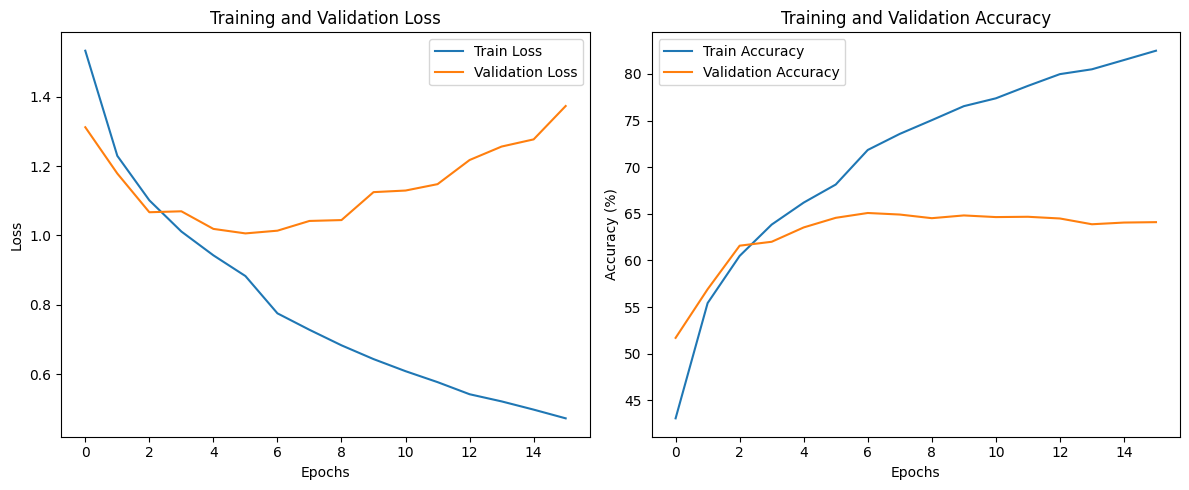

In [17]:
# Plot training curves
plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

In [16]:
# Evaluate on test set
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-class accuracy
            for i in range(labels.size(0)):
                label = labels[i]
                pred = predicted[i]
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1
    
    # Print accuracy
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    
    # Print per-class accuracy
    for i in range(num_classes):
        if class_total[i] > 0:
            print(f"Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%")

print("\nEvaluating on test set...")
evaluate(model, test_loader, device)

# Save the trained model
torch.save(model.state_dict(), 'models/cnn_model.pth')
print("Model saved to 'models/cnn_model.pth'")


Evaluating on test set...
Test Accuracy: 64.03%
Accuracy of airplane: 74.29%
Accuracy of automobile: 68.18%
Accuracy of bird: 60.61%
Accuracy of cat: 50.88%
Accuracy of deer: 59.43%
Accuracy of dog: 42.74%
Accuracy of frog: 78.38%
Accuracy of horse: 66.64%
Accuracy of ship: 68.81%
Accuracy of truck: 70.36%
Model saved to 'models/cnn_model.pth'
